In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as tc

We import the provided rnn.py script. <br>
Some small modifications had to be made to run on my machine without warnings.

In [2]:
import rnn

# Task 1

In [3]:
data = tc.load('lorenz63.pt')
data.shape

torch.Size([100000, 3])

## Task 1a

<Axes3DSubplot:>

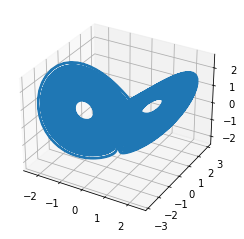

In [4]:
rnn.plot3D(data)

## Task 1b

Before we can train our model we need to find sensible hyperparameters:

For the hidden dimensionality of our model we can choose something rather large, since we employ L1 regularization. If our model be too big, L1 regularization should mitigate most of the overfitting.

In [5]:
hidden_dim = 50

For the sequence lenght we should choose a value that allows the network to roughly learn the bahavior of the system on every single sequence. The sequence lenght should thus be large enough to include at least one 'wing' of the lorentz attractor. <br>
We should also make sure however that the sequences arent too long, because the MSE loss cannot properly deal with the chaotic behavior of the system (see 1c). <br>
We will check what the appropriate lenght is by plotting subsequences of the data:

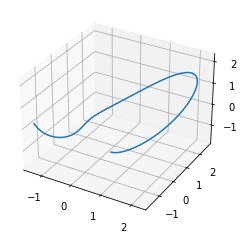

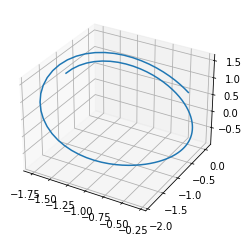

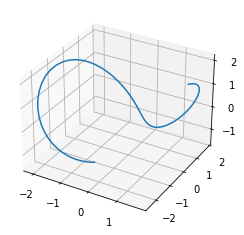

In [6]:
seq_length = 90

for i in range(3):
    start = np.random.randint(0, data.shape[0] - seq_length)
    data_ = data[start:start+seq_length]
    
    rnn.plot3D(data_)

The batch size should be more or less arbitrary I believe... <br>
Although it might be beneficial to again include a full picture of the system in every epoch, thus the batch size should not be too small.

In [7]:
batch_size = 50

Regularization strenght

In [8]:
alpha = 0.1

With this we can train our model:

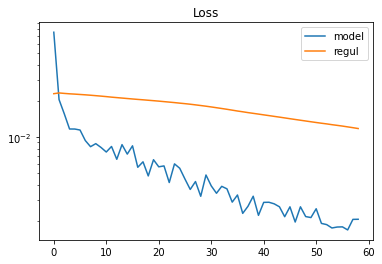

In [17]:
model, loss = rnn.train(rnn.latent_RNN(data.shape[1], hidden_dim), data, 3000, batch_size, seq_length, alpha, False)

<Axes3DSubplot:>

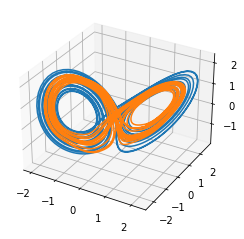

In [18]:
rnn.plot_generated(data[:2000], model)

These results look pretty good!

## Task 1c and 1d

In [19]:
prediction = model.generate(500, data[:1], tc.randn((1, model.latent_dim)))

In [20]:
tc.nn.MSELoss()(data[:500], prediction).item()

1.6292920112609863

The prediction doesnt seem to match the data vary well. <br>
Due to the chaos of the system we are trying to model, we really cant expect our model to perform too well when using MSE loss as a metric for success. <br>
Even two very similar lorentz system will have high MSE losses for long time series, so our model would have to be a perfect approximation of the system to even have a chance.

## Task 1e

In [13]:
class GRU(tc.nn.Module):
    def __init__(self, obs_dim, latent_dim):
        super().__init__()
        self.obs_dim = obs_dim
        self.latent_dim = latent_dim
        self.GRU = tc.nn.GRU(obs_dim, latent_dim)
        self.observation_model = tc.nn.Linear(latent_dim, obs_dim)
    
    def forward(self, time_series, h0):
        out, h = self.GRU(time_series, h0)
        obs = self.observation_model(out)
        return obs, h
        
    def generate(self, T, x0, h0):
        prediction = tc.zeros((T, self.obs_dim))
        x = x0
        h = h0
        for t in range(T):
            prediction[t] = x.squeeze()
            x, h = self(x, h)
        return prediction

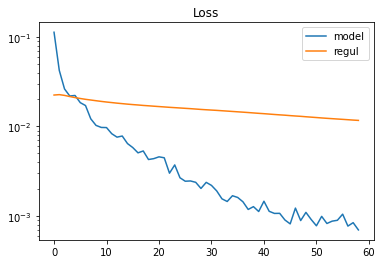

In [14]:
model, loss = rnn.train(GRU(data.shape[1], hidden_dim), data, 3000, batch_size, seq_length, alpha, False)

In [15]:
prediction = model.generate(500, data[:1], tc.randn((1, model.latent_dim)))

In [16]:
tc.nn.MSELoss()(data[:500], prediction).item()

1.5625498294830322

This is not really significantly better... The loss hasnt converged completly so training the network more could reduce the error further.

# Task 2

- f diverges: <br>
    A network of dimension n = 1 should suffice. <br>
    For example A = 1, W = 0, h = 1 will result in z_t = z_t-1 + 1 which diverges.
- f has one fixed point: <br>
    The linear part of the network is still enough -> n = 1 <br>
    For example A = 0.5, W = 0, h = 0 will result in an attracting fixed point at x = 0
- f has m fixed points: <br>
    As we saw above, the linear part of the network can produce one fixed point. <br>
    The nonlinearity (ReLU) should be able to produce one stable fixed point at best, my guess is that we need a network of at least dimension n = m
- f has a cycle of order 2: <br>
    A network with dimension n = 2 should be enough. <br>
    Its easy to construct a network that just swaps the values of the two hidden neurons via the W matrix.
- f has a cycle of order c > 2: <br>
    A network of size n = c is enough. <br>
    Again we can just construct a network that cycles the entries of the c hidden neurons creating a c-order cycle.
- f is chaotic: <br>
    Even small models should be able to achieve chaotic behavior. A single neuron doesnt work (i think) but two should be enough, especially since at two neurons the non linearity is introduced.